## Imports

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import shap
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from statsmodels.graphics.regressionplots import plot_partregress

# Client Views

## Load and Clean Data

In [7]:
df = pd.read_csv('client.csv')
df.head()

,profileviewtimestamp,candidateId,profileid,firstname,lastname,profilepicture,pitchvideo,searchstatus,gender,race,school,graduationyear,degree,company,position,monthsatcompany,profileviews
0,7/26/21 18:23,21920,37245,Michael,Mosher,1,0,2,NaN,NaN,Santa Clara University,NaN,Bachelors,NS1,Account Executive,35,2
1,6/29/21 13:07,141097,276853,Lacey,Habicht,1,0,4,NaN,NaN,St. Francis College,2014.0,Bachelors,Kaseya,Senior Enterprise Account Manager,2,1
2,7/30/21 18:10,42843,328841,Conor,House,1,0,4,Male,White,Miami University,2015.0,Bachelors,Paycom,Sales Representative,4,3
3,7/29/21 18:33,18280,315894,Sarah,Walker,1,0,4,Female,White,The University of the South,2010.0,Bachelors,Staffbase (#1 employee app solution),Account Executive,15,6
4,7/14/21 15:02,88499,293670,Mark,Hernandez,1,0,4,NaN,NaN,National University,NaN,Masters,"Celestix Networks, Inc.",Account Executive,54,2


In [8]:
print(df.shape)

(4476, 17)


In [9]:
cv = df.drop(columns=['profileviewtimestamp', 'candidateId',
                      'profileid', 'firstname', 'lastname', 'school',
                      'company', 'position'])
cv.head()

,profilepicture,pitchvideo,searchstatus,gender,race,graduationyear,degree,monthsatcompany,profileviews
0,1,0,2,NaN,NaN,NaN,Bachelors,35,2
1,1,0,4,NaN,NaN,2014.0,Bachelors,2,1
2,1,0,4,Male,White,2015.0,Bachelors,4,3
3,1,0,4,Female,White,2010.0,Bachelors,15,6
4,1,0,4,NaN,NaN,NaN,Masters,54,2


## Replace Null Values

In [11]:
cv.isnull().sum()

profilepicture        0
pitchvideo            0
searchstatus          0
gender             2372
race               2407
graduationyear      637
degree               12
monthsatcompany       0
profileviews          0
dtype: int64

In [13]:
cv.dropna(subset=['degree'], inplace=True)
cv['gender'].fillna("Unknown", inplace=True)
cv['race'].fillna("Unknown", inplace=True)
cv.dropna(subset=['graduationyear'], inplace=True)

In [14]:
cv.isnull().sum()

profilepicture     0
pitchvideo         0
searchstatus       0
gender             0
race               0
graduationyear     0
degree             0
monthsatcompany    0
profileviews       0
dtype: int64

In [15]:
cv.shape

(3839, 9)

## Declare Independent Variables and Target Variable

In [16]:
X = cv.drop(columns=['profileviews'])
y = cv['profileviews']
X.head()

,profilepicture,pitchvideo,searchstatus,gender,race,graduationyear,degree,monthsatcompany
1,1,0,4,Unknown,Unknown,2014.0,Bachelors,2
2,1,0,4,Male,White,2015.0,Bachelors,4
3,1,0,4,Female,White,2010.0,Bachelors,15
5,1,0,4,Male,White,2016.0,Bachelors,17
6,1,0,2,Male,White,2018.0,Bachelors,13


## Encode Categorical Variables for the Model

In [17]:
X = pd.get_dummies(X, columns=['gender', 'race', 'degree'])
X = X.drop(columns=['gender_Unknown', 'race_Unknown', 'degree_Other'])
X.head()

,profilepicture,pitchvideo,searchstatus,graduationyear,monthsatcompany,gender_Female,gender_I prefer not to respond,gender_Male,race_Alaskan Native or Native American,race_Asian,race_Black or African American,race_Hispanic or Latino,race_I prefer not to respond,race_Native Hawaiian or Other Pacific Islander,race_White,degree_Associates,degree_Bachelors,degree_Diploma,degree_Masters,degree_PhD
1,1,0,4,2014.0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,4,2015.0,4,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
3,1,0,4,2010.0,15,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
5,1,0,4,2016.0,17,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
6,1,0,2,2018.0,13,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0


## Check Distribution and Remove Outliers

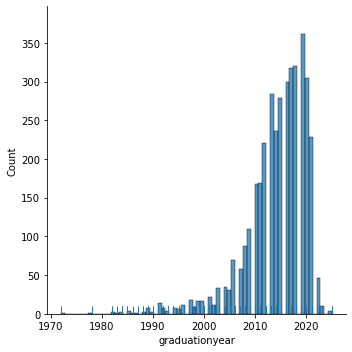

In [18]:
sns.displot(cv.graduationyear, rug=True)

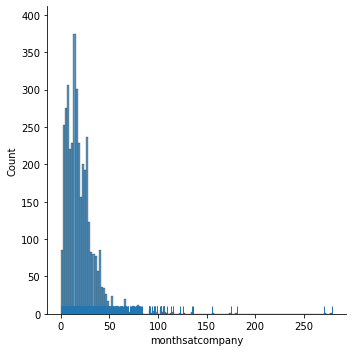

In [19]:
sns.displot(cv.monthsatcompany, rug=True)

In [20]:
cv = cv.loc[cv['graduationyear'] > 1982]
cv = cv.loc[cv['monthsatcompany'] < 250]

## Choose Model Based on Accuracy Score

In [21]:
mse_gb = -cross_val_score(GradientBoostingRegressor(), X, y, cv=100, scoring='neg_root_mean_squared_error')
mse_rf = -cross_val_score(RandomForestRegressor(n_estimators=1000), X, y, cv=100, scoring = 'neg_root_mean_squared_error')

print('Average MSE for GradientBoostingRegressor is {0:.3f}'.format(np.mean(mse_gb)))
print('Average MSE for RandomForestRegressor is {0:.3f}'.format(np.mean(mse_rf)))

Average MSE for GradientBoostingRegressor is 1.182
Average MSE for RandomForestRegressor is 1.308


## Check for Variable Correlations with Scatter Plot

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


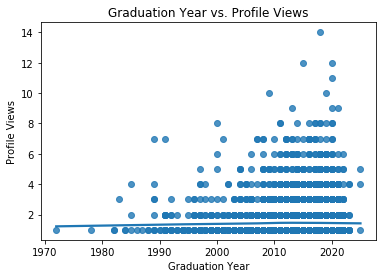

In [22]:
sns.regplot(X['graduationyear'], y, lowess=True)
plt.ylabel('Profile Views')
plt.xlabel('Graduation Year')
plt.title('Graduation Year vs. Profile Views')
plt.show()

## Build Model

In [23]:
rf = RandomForestRegressor(n_estimators=1000).fit(X,y)

In [24]:
gb = GradientBoostingRegressor().fit(X,y)

## Check Which Features are Most Important

In [25]:
importance = shap.TreeExplainer(gb)
shap_values = importance.shap_values(X)

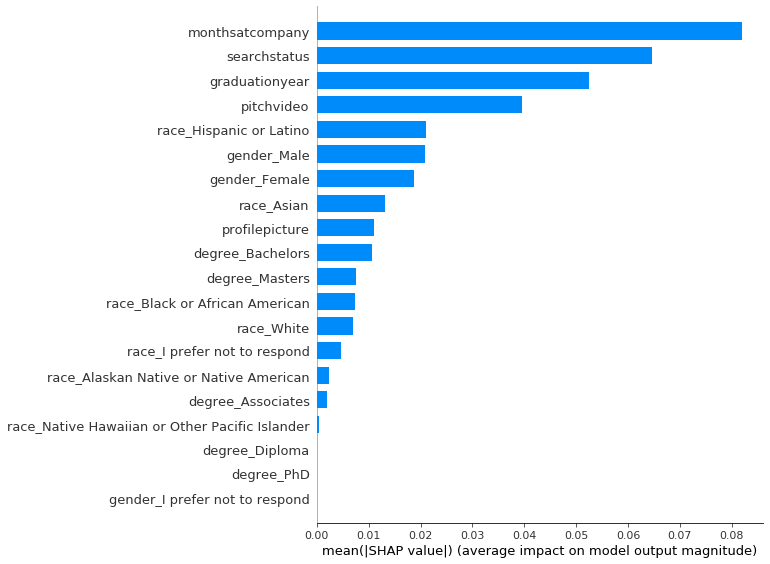

In [26]:
shap.summary_plot(shap_values, X, plot_type='bar')

## Plot Partial Dependence of Numerical Variables

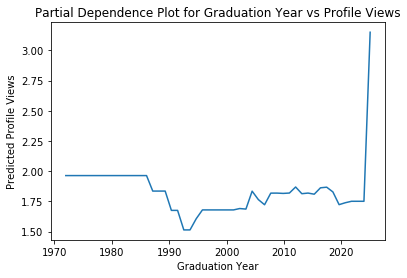

In [27]:
gy_values = np.linspace(np.min(X['graduationyear']), np.max(X['graduationyear']))

pdp_gy = []
for n in gy_values:
    X_gy = X.copy()
    X_gy['graduationyear'] = n
    pdp_gy.append(np.mean(gb.predict(X_gy)))
    
plt.plot(gy_values, pdp_gy)
plt.ylabel('Predicted Profile Views')
plt.xlabel('Graduation Year')
plt.title('Partial Dependence Plot for Graduation Year vs Profile Views')
plt.show()

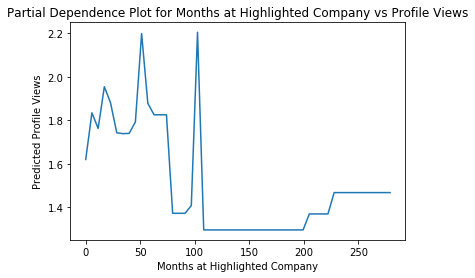

In [28]:
mc_values = np.linspace(np.min(X['monthsatcompany']), np.max(X['monthsatcompany']))

pdp_mc = []
for n in mc_values:
    X_mc = X.copy()
    X_mc['monthsatcompany'] = n
    pdp_mc.append(np.mean(gb.predict(X_mc)))
    
plt.plot(mc_values, pdp_mc)
plt.ylabel('Predicted Profile Views')
plt.xlabel('Months at Highlighted Company')
plt.title('Partial Dependence Plot for Months at Highlighted Company vs Profile Views')
plt.show()

## Plot Partial Dependence of Categorical Variables

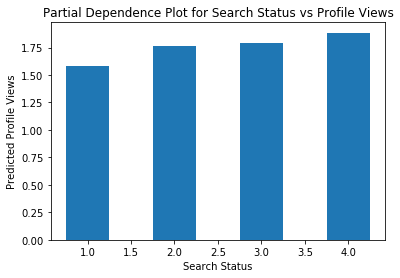

In [29]:
ss_values = np.array(X['searchstatus'])
pdp_ss = []
for n in ss_values:
    X_ss = X.copy()
    X_ss['searchstatus'] = n
    pdp_ss.append(np.mean(gb.predict(X_ss)))
    
plt.bar(ss_values, pdp_ss, width=0.5)
plt.ylabel('Predicted Profile Views')
plt.xlabel('Search Status')
plt.title('Partial Dependence Plot for Search Status vs Profile Views')
plt.show()


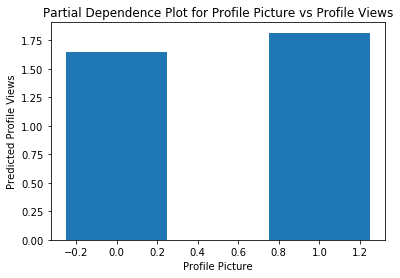

In [30]:
pp_values = np.array(X['profilepicture'])
pdp_pp = []
for n in pp_values:
    X_pp = X.copy()
    X_pp['profilepicture'] = n
    pdp_pp.append(np.mean(gb.predict(X_pp)))
    
plt.bar(pp_values, pdp_pp, width=0.5)
plt.ylabel('Predicted Profile Views')
plt.xlabel('Profile Picture')
plt.title('Partial Dependence Plot for Profile Picture vs Profile Views')
plt.show()


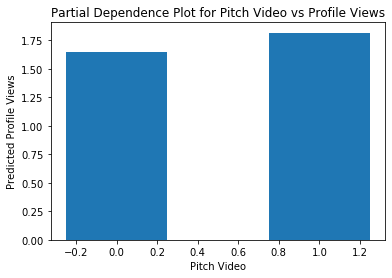

In [31]:
pv_values = np.array(X['pitchvideo'])
pdp_pv = []
for n in pv_values:
    X_pv = X.copy()
    X_pv['profilepicture'] = n
    pdp_pv.append(np.mean(gb.predict(X_pv)))
    
plt.bar(pv_values, pdp_pv, width=0.5)
plt.ylabel('Predicted Profile Views')
plt.xlabel('Pitch Video')
plt.title('Partial Dependence Plot for Pitch Video vs Profile Views')
plt.show()